In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from Bio.PDB import qcprot

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

import warnings
warnings.filterwarnings("ignore")

C:\Users\kbane\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extrapolate_points(points, n):
    n1 = len(points)
    total_len = n1 - 1
    points_new = [points[0]]
    for i in range(1, n):
        curr_len = total_len * i / (n - 1)
        p1 = points[int(curr_len // 1)]
        if curr_len // 1 == n1 - 1:
            points_new.append(p1)
        else:
            p2 = points[int(curr_len // 1) + 1]
            alpha = curr_len % 1
            p = (p1[0] * (1 - alpha) + p2[0] * alpha, p1[1] * (1 - alpha) + p2[1] * alpha,
                 p1[2] * (1 - alpha) + p2[2] * alpha)
            points_new.append(p)
    return points_new

def get_qcp_fit_model(image_structure, gd_structure):
    """
    applying the QCP transformation to fit into the points of the image
    :param image_structure: list of points from the image to which other structure is to be transformed
    :param gd_structure: structure to transform
    :return: transformed structure
    """
    n = len(image_structure)
    gd_points = np.array(extrapolate_points(gd_structure, n))
    qcp_transformation = qcprot.QCPSuperimposer()
    qcp_transformation.set(reference_coords=np.array(image_structure), coords=gd_points)
    qcp_transformation.run()
    return qcp_transformation.get_transformed()

In [4]:
def kabsch(P, Q):
    """Aligns P onto Q using the Kabsch algorithm."""
    # Subtract centroids
    Pc = P - P.mean(axis=0)
    Qc = Q - Q.mean(axis=0)

    # Covariance matrix
    C = np.dot(Pc.T, Qc)

    # Singular value decomposition
    V, S, Wt = np.linalg.svd(C)
    d = np.sign(np.linalg.det(np.dot(V, Wt)))
    D = np.diag([1, 1, d])

    # Optimal rotation
    U = np.dot(np.dot(V, D), Wt)

    # Save the transformation
    rotation = U
    translation = Q.mean(axis=0) - np.dot(P.mean(axis=0), U)

    return rotation, translation

def apply_transformation(X, rotation, translation):
    """Apply saved transformation to structure X."""
    return np.dot(X, rotation) + translation

# ChAIR data overview

In [3]:
df = pd.read_csv("../data/data_ChAIR/single_cell/patski.dis.stat.txt", sep='\t')
df.head()

,cellid,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo,nCount_ATAC,nFeature_ATAC,TSS.enrichment,TSS.percentile,...,singleG2M.Score,singlePhase,S.Score,G2M.Score,Phase,PC_1,PC_2,contact_number,distance,metacell
0,SCG0092_GCCTGCTGTGAGCGAA-1,SCG0092,2121,1524,6.748466,8.128834,5298,2620,1.873637,0.89,...,0.002406,G2M,-0.108243,-0.000510,G1,0.502462,2.418657,2574,8.086016,G1_0
1,SCG0090_TTCCTTGAGTAGCGGG-1,SCG0090,3913,2462,6.525535,4.714099,7197,3357,2.313965,0.93,...,-0.017008,G1,-0.071187,-0.015068,G1,1.180161,1.525348,2354,7.113897,G1_0
2,SCG0089_TCGTTATTCTGTAATG-1,SCG0089,2227,1621,6.056130,5.612999,2637,1296,2.348871,0.94,...,0.003201,G2M,-0.073382,-0.003418,G1,0.524131,2.148319,837,6.724441,G1_0
3,SCG0090_CTAGTGAGTATTTGGG-1,SCG0090,1877,1345,6.600518,7.722174,2518,1225,2.564103,0.95,...,-0.041638,G1,-0.098018,-0.043666,G1,-0.249158,2.768435,854,5.636900,G1_0
4,SCG0088_GTCTTGCTCAAACCGT-1,SCG0088,3034,2063,8.182064,5.147656,5662,2614,2.868243,0.97,...,-0.006544,G1,-0.120537,-0.007400,G1,0.676222,1.749475,1963,5.414676,G1_0


# Clustering of ChromMovie derived motifs

### Converting cif to pandas DataFrame

In [4]:
def read_cif(path):
    df = pd.DataFrame(columns=["chr", "x", "y", "z"])
    with open(path, 'r') as f:
        for line in f:
            if line.startswith("ATOM"):
                line_split = line.split()
                chrom = line_split[6]
                x, y, z = line_split[-3:]
                df.loc[df.shape[0]] = [chrom, x, y, z]
    return df

In [5]:
path = "../data/ChromMovie/test_099/frames_cif"
path_out = "../data/ChromMovie/test_099/frames_pd"
files = os.listdir(path)

In [7]:
for file in tqdm(files):
    if file.startswith("step099"):
        df = read_cif(os.path.join(path, file))
        df.to_csv(os.path.join(path_out, file.split(".")[0]+".csv"))

### Extracting stuctural motifs

In [5]:
path_out = "../data/ChromMovie/test_099/frames_pd"
files_df = os.listdir(path_out)
files_df.sort()
dfs = [pd.read_csv(os.path.join(path_out, file), index_col=0) for file in files_df]

In [116]:
def get_kmers(dfs, length=200, width=5):
    n = len(dfs)
    kmers = []
    reference_structure = np.array(dfs[0][['x', 'y', 'z']].iloc[0:length,:])
    
    for i in tqdm(range(dfs[0].shape[0]-length)):
        if i%length==0:
            chrom = dfs[0]["chr"].iloc[i]
            chrom_end = dfs[0]["chr"].iloc[i+length-1]
            if chrom == chrom_end:
                for df_id in range(n-width+1):
                    if df_id%width == 0:
                        sub_structures = []
                        for j in range(width):
                            structure_array = np.array(dfs[df_id+j][['x', 'y', 'z']].iloc[i:i+length,:])
                            # if j==0:
                            #     R, t = kabsch(structure_array, reference_structure)
                            # structure_array = apply_transformation(structure_array, R, t)
                                
                            structure_array = get_qcp_fit_model(reference_structure, structure_array)
                            flat_vector = structure_array.flatten()
                            flat_vector = flat_vector - flat_vector.mean()
                            sub_structures.append(flat_vector)
                        kmers.append( np.hstack(sub_structures) )
    return np.vstack(kmers)


def get_angle(A, B, C):
    BA = A - B
    BC = C - B
    cos_angle = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))
    
    # Handle numerical inaccuracies
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    
    angle_rad = np.arccos(cos_angle)
    # angle_deg = np.degrees(angle_rad)
    return angle_rad

# def get_kmers(dfs, length=200, width=5):
#     n = len(dfs)
#     kmers = []
#     reference_structure = np.array(dfs[0][['x', 'y', 'z']].iloc[0:length,:])
    
#     for i in tqdm(range(dfs[0].shape[0]-length)):
#         if i%length==0:
#             chrom = dfs[0]["chr"].iloc[i]
#             chrom_end = dfs[0]["chr"].iloc[i+length-1]
#             if chrom == chrom_end:
#                 for df_id in range(n-width+1):
#                     if df_id%width == 0:
#                         sub_angles = []
#                         for j in range(width):
#                             structure_array = np.array(dfs[df_id+j][['x', 'y', 'z']].iloc[i:i+length,:])
#                             for k in range(structure_array.shape[0] - 3 + 1):
#                                 sub_angles.append(get_angle(structure_array[k,:], structure_array[k+1,:], structure_array[k+2,:]))
#                             # for k in range(structure_array.shape[0] - 4 + 1):
#                             #     sub_angles.append(get_angle(structure_array[k,:], structure_array[k+1,:], structure_array[k+3,:]))
                            
#                         kmers.append( np.hstack(sub_angles) )
#     return np.vstack(kmers)

In [117]:
length, width = 10, 3
kmers = get_kmers(dfs, length=length, width=width)
np.save(f"../results/kmers/kmers_l{length}_w{width}.npy", kmers)

100%|██████████████████████████████████████████████████████████████████████████| 26352/26352 [00:21<00:00, 1199.02it/s]


In [57]:
length, width = 50, 5
chrom = "chr1-P"
dfs2 = [df[df["chr"]==chrom] for df in dfs]
kmers = get_kmers(dfs2, length=length, width=width)
np.save(f"../results/kmers/kmers_l{length}_w{width}_{chrom}.npy", kmers)

100%|███████████████████████████████████████████████████████████████████████████████| 928/928 [00:05<00:00, 179.89it/s]


### Load existing kmer information

In [118]:
# length, width = 20, 5
kmers = np.load(f"../results/kmers/kmers_l{length}_w{width}.npy")
# kmers = kmers[:2000, :]

# length, width = 20, 5
# chrom = "chr1-M"
# kmers = np.load(f"../results/kmers/kmers_l{length}_w{width}_{chrom}.npy")

kmers.shape

(13010, 90)

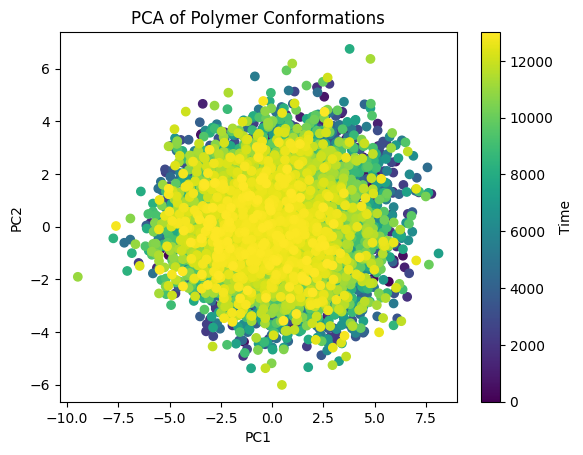

In [119]:
pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(kmers)

plt.scatter(reduced_pca[:, 0], reduced_pca[:, 1], c=range(len(reduced_pca)), cmap='viridis')
plt.title('PCA of Polymer Conformations')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Time')
plt.show()

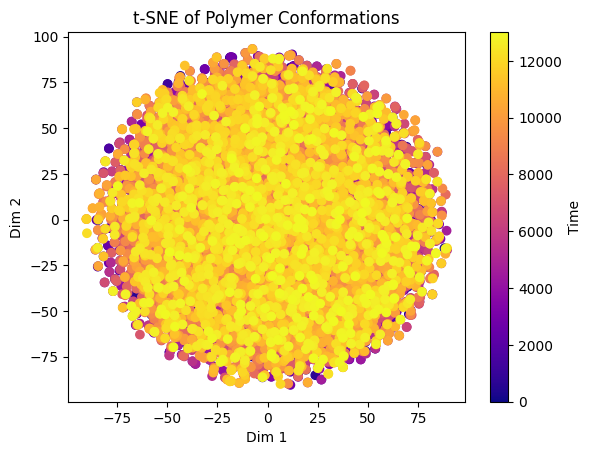

In [91]:
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
reduced_tsne = tsne.fit_transform(kmers)

plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], c=range(len(reduced_tsne)), cmap='plasma')
plt.title('t-SNE of Polymer Conformations')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.colorbar(label='Time')
plt.show()

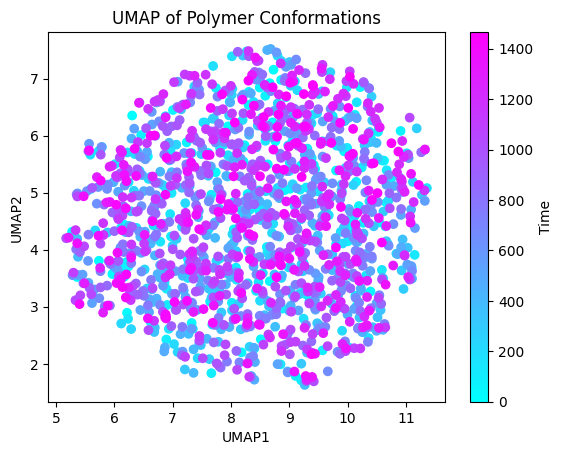

In [85]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='euclidean', random_state=42)
reduced_umap = reducer.fit_transform(kmers)

plt.scatter(reduced_umap[:, 0], reduced_umap[:, 1], c=range(len(reduced_umap)), cmap='cool')
plt.title('UMAP of Polymer Conformations')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Time')
plt.show()

# Clustering

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [120]:
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(kmers)
data_scaled = kmers

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:30<00:00,  1.69s/it]


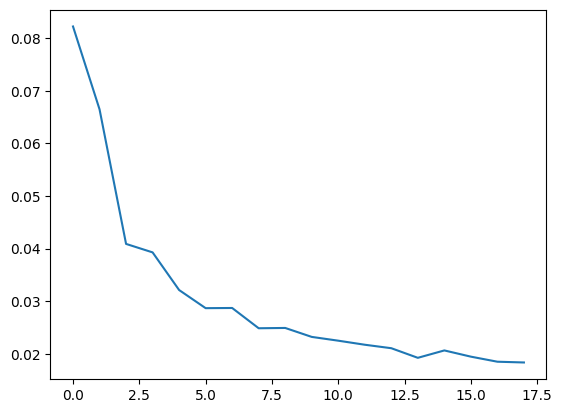

In [121]:
scores = []
for n_clusters in tqdm(range(2,20)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    scores.append(silhouette_score(data_scaled, labels))
plt.plot(scores)
plt.show()

Number of clusters: 5
Silhouette Score: 0.0393


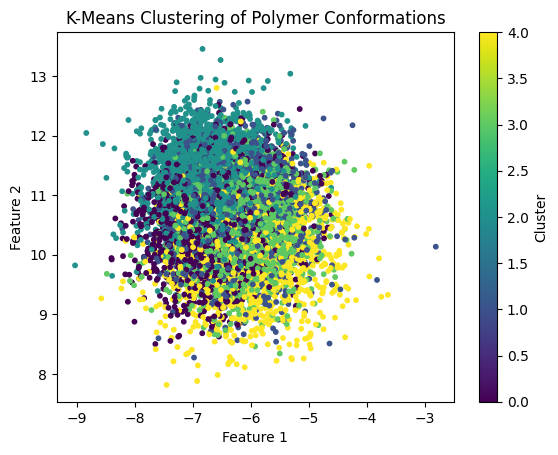

In [122]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(data_scaled)

print(f"Number of clusters: {len(np.unique(labels))}")
score = silhouette_score(data_scaled, labels)
print(f"Silhouette Score: {score:.4f}")

plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=labels, cmap='viridis', s=10)
plt.title('K-Means Clustering of Polymer Conformations')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

Number of clusters: 1


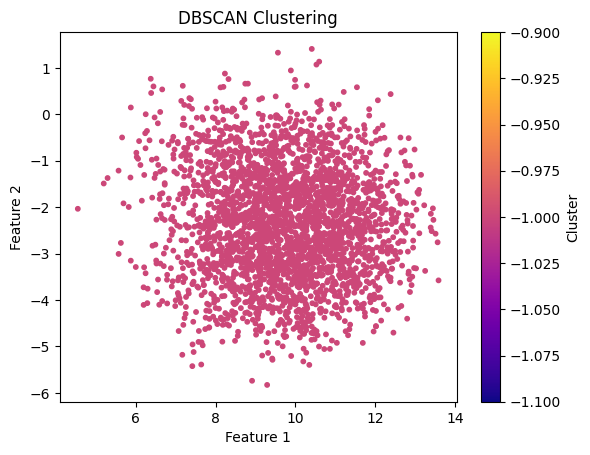

In [69]:
dbscan = DBSCAN(eps=2.0, min_samples=10)
labels = dbscan.fit_predict(data_scaled)

print(f"Number of clusters: {len(np.unique(labels))}")
# score = silhouette_score(data_scaled, labels)
# print(f"Silhouette Score: {score:.2f}")

plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=labels, cmap='plasma', s=10)
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

Number of clusters: 4
Silhouette Score: 0.04


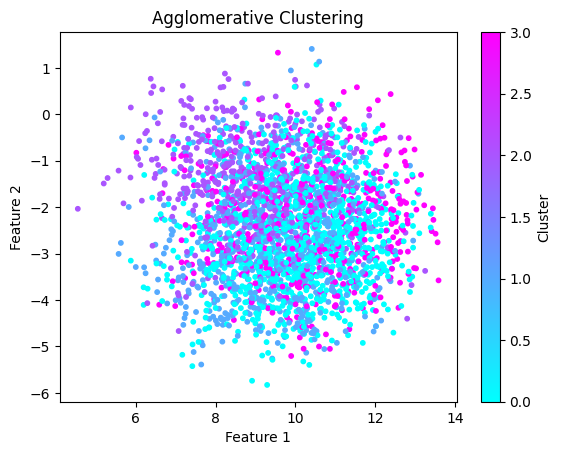

In [75]:
agglo = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = agglo.fit_predict(data_scaled)

print(f"Number of clusters: {len(np.unique(labels))}")
score = silhouette_score(data_scaled, labels)
print(f"Silhouette Score: {score:.2f}")

plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=labels, cmap='cool', s=10)
plt.title('Agglomerative Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

# FDA

In [152]:
############# Creation of mmcif and psf files #############
mmcif_atomhead = """data_nucsim
# 
_entry.id nucsim
# 
_audit_conform.dict_name       mmcif_pdbx.dic 
_audit_conform.dict_version    5.296 
_audit_conform.dict_location   http://mmcif.pdb.org/dictionaries/ascii/mmcif_pdbx.dic 
# ----------- ATOMS ----------------
loop_
_atom_site.group_PDB 
_atom_site.id 
_atom_site.type_symbol 
_atom_site.label_atom_id 
_atom_site.label_alt_id 
_atom_site.label_comp_id 
_atom_site.label_asym_id 
_atom_site.label_entity_id 
_atom_site.label_seq_id 
_atom_site.pdbx_PDB_ins_code 
_atom_site.Cartn_x 
_atom_site.Cartn_y 
_atom_site.Cartn_z
"""

mmcif_connecthead = """#
loop_
_struct_conn.id
_struct_conn.conn_type_id
_struct_conn.ptnr1_label_comp_id
_struct_conn.ptnr1_label_asym_id
_struct_conn.ptnr1_label_seq_id
_struct_conn.ptnr1_label_atom_id
_struct_conn.ptnr2_label_comp_id
_struct_conn.ptnr2_label_asym_id
_struct_conn.ptnr2_label_seq_id
_struct_conn.ptnr2_label_atom_id
"""


def write_mmcif(points, cif_file_name='struct.cif', breaks=[], chroms=['A']):
    atoms = ''
    n = len(points)
    chrom_id = 0
    for i in range(0,n):
        x = points[i][0]
        y = points[i][1]
        try:
            z = points[i][2]
        except IndexError:
            z = 0.0
        atoms += f"ATOM {i+1} D CA . CHR {chroms[chrom_id]} {i+1} {i+1} ? {x:.3f} {y:.3f} {z:.3f}\n"
        if i in breaks:
            chrom_id += 1
            chrom_id = chrom_id%len(chroms)

    connects = ''
    chrom_id = 0
    j = 0
    for i in range(0,n-1):
        if i not in breaks:
            connects += f'C{j} covale CHR {chroms[chrom_id]} {i+1} CA CHR {chroms[chrom_id]} {i+2} CA\n'
            j += 1
        else:
            chrom_id += 1
            chrom_id = chrom_id%len(chroms)

    # Save files
    ## .pdb
    cif_file_content = mmcif_atomhead+atoms+mmcif_connecthead+connects

    with open(cif_file_name, 'w') as f:
        f.write(cif_file_content)


def write_pdb(points, path_out):
    n = points.shape[0]
    with open(path_out, 'w') as f:
        for i in range(n):
            vals = ["HETATM", str(i), "B", "BEA", "A", str(i), str(points[i,0]), str(points[i,1]), str(points[i,2]),  "1.00",  "0.00", "B"]
            f.write("\t".join(vals)+"\n")
        f.write("\t".join(["TER", str(n), "BEA", "A", str(n-1)])+"\n")
        for i in range(n):
            if i==0:
                f.write("CONNECT\t1\t2\n")
            elif i==n-1:
                f.write(f"CONNECT\t{str(n)}\t{str(n-1)}\n")
            else:
                vals = ["CONECT", str(i+1), str(i), str(i+2)]
                f.write("\t".join(vals)+"\n")
        f.write("END\n")
      


In [123]:
kmers.shape

(13010, 90)

In [128]:
centroids = kmeans.cluster_centers_

In [130]:
len(centroids)

5

In [131]:
len(centroids[0])

90

In [153]:
path_out = "../results/centroids"

for i in range(len(centroids)):
    structures = []
    for w in range(width):
        structure = centroids[i][w*length*3 : (w+1)*length*3]
        structure = np.array(structure).reshape((length,3))
        structures.append(structure)
    
    directory = os.path.join(path_out, f"centroid_{i}")
    if not os.path.exists(directory): os.makedirs(directory)
    for j, structure in enumerate(structures):
        write_mmcif(structure, cif_file_name=os.path.join(path_out, f"centroid_{i}", f"frame{j}.cif"))
        write_pdb(structure, path_out=os.path.join(path_out, f"centroid_{i}", f"frame{j}.pdb"))

In [138]:
structures[0]

array([[-6.55024671, 10.62240846, -4.31768899],
       [-6.61173442, 10.6102527 , -4.18419583],
       [-6.67175571, 10.58329905, -3.97736199],
       [-6.57823246, 10.51066635, -3.80925221],
       [-6.31655065, 10.29453203, -3.86538225],
       [-6.13564853,  9.97285248, -3.88329188],
       [-5.87555907,  9.67286526, -3.83757066],
       [-5.7073464 ,  9.3469727 , -3.69011744],
       [-5.58217784,  9.15432943, -3.48094534],
       [-5.49641487,  9.14415488, -3.3408601 ]])